<a href="https://colab.research.google.com/github/jamesrichter/Housing-dataset/blob/main/House_price_estimation_from_visual_and_textual_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dataset**

This is the dataset proposed and introduces in our paper: "House price estimation from visual and textual features"
https://arxiv.org/pdf/1609.08399.pdf


## **Cite**
If you are using this dataset, please, cite our paper: 
@article{ahmed2016house,
  title={House price estimation from visual and textual features},
  author={Ahmed, Eman and Moustafa, Mohamed},
  journal={arXiv preprint arXiv:1609.08399},
  year={2016}
}

## **Details**

1. Title: Houses Dataset

2. Description:  This is a benchmark dataset for houses prices that contains both visual and textual information. Each house is represened by four images for bedroom, bathroom, kitchen and a frontal image of the house. This is the first dataset that contains images to be used for houses prices estimation. The dataset folder contains 2140 images, 4 images for each house. Also, it contains a text file that contains the textual metadata of the dataset. Each row in the file respesents the number of house in order. The numbers represent number of bedrooms, number of bathrooms, area of the house, zipcode and the price. 

3. Usage:  In order to use this dataset, please, cite the paper and the dataset:  

H. Ahmed E. and Moustafa M. (2016). House Price Estimation from Visual and Textual Features.In Proceedings of the 8th International Joint Conference on Computational Intelligence (IJCCI 2016)ISBN 978-989-758-201-1, pages 62-68. DOI: 10.5220/0006040700620068


4. Number of Instances: 535

5. Number of Attributes: 4 textual attributes in addition to the visual attributes that can be extracted from the images. 

6. Attribute Information:
    1. Number of Bedrooms      
    2. Number of bathrooms   
    3. Area
    4. Zipcode
    5. Price

7. Missing Attribute Values:  None.

In [1]:
!pip install --upgrade tensorflow

In [2]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
%matplotlib inline
import glob
from IPython.display import Image
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping

# Shared Input Layer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate

import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt

import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image


from google.colab import drive
drive.mount('/content/drive')
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [3]:
## Bathroom.jpg
new_images=[]
for number in range(1, 536):
    for path in glob.glob("./drive/My Drive/Houses-dataset/Houses Dataset/" + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
          new_images.append(path) 

print(new_images)

['./drive/My Drive/Houses-dataset/Houses Dataset/1_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/2_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/3_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/4_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/5_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/6_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/7_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/8_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/9_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/10_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/11_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/12_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/13_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/14_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/15_bathroom.jpg', './drive/My Drive/

In [4]:
img= pd.DataFrame(new_images,columns = ['bathroom_img'])

## bedroom images
bedroom_images = []
for number in range(1, 536):
    for path in glob.glob("./drive/My Drive/Houses-dataset/Houses Dataset/" + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path) 


img['bedroom_img']=bedroom_images

frontal_images = []
for number in range(1, 536):
    for path in glob.glob("./drive/My Drive/Houses-dataset/Houses Dataset/" + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path) 

img['frontal_img']=frontal_images

kitchen_images = []
for number in range(1, 536):
    for path in glob.glob("./drive/My Drive/Houses-dataset/Houses Dataset/" + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path) 

img['kitchen_img']=kitchen_images


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


path = "./drive/"
    
filename = os.path.join(path,"My Drive/Houses-dataset/Houses Dataset/HousesInfo.txt")    
cols=["Bedrooms","Bathrooms","area","zipcode","price"]
df = pd.read_csv(filename , sep=" ", header=None , names=cols)
df.head()

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [5]:
from sklearn import preprocessing
# normalizedValues = df.area
# df.area = normalizedValues / normalizedValues.std()


# normalize price
# Create x, where x the 'scores' column's values as floats
x = df[['price']].values

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
normalized = pd.DataFrame(x_scaled)
df.area = normalized

# normalize bathrooms
# Create x, where x the 'scores' column's values as floats
x = df[['Bathrooms']].values
x_scaled = min_max_scaler.fit_transform(x)
normalized = pd.DataFrame(x_scaled)
df.Bathrooms = normalized

# normalize bathrooms
# Create x, where x the 'scores' column's values as floats
x = df[['Bedrooms']].values
x_scaled = min_max_scaler.fit_transform(x)
normalized = pd.DataFrame(x_scaled)
df.Bedrooms = normalized

# zipcodes = df["zipcode"].value_counts().keys().tolist()
# counts = df["zipcode"].value_counts().tolist()
# for (zipcode, count) in zip(zipcodes, counts):
# 		if count < 10:
# 			idxs = df[df["zipcode"] == zipcode].index
# 			print(idxs)
      # df.drop(idxs, inplace=True)
   
# prices = df["price"].value_counts().keys().tolist()
prices = df['price']
i = 0
j = 0
for price in prices:
  if price <= 100000:
    j += 1
    img.drop(int(i), inplace=True)
    df.drop(int(i), inplace=True)
  elif price >= 900000:
    j += 1
    img.drop(int(i), inplace=True)
    df.drop(int(i), inplace=True)
  i += 1

# df.head()
# print(j)
# print(i)
# print(df.shape)

In [6]:
df = pd.get_dummies(df, columns=['zipcode'])

In [7]:
df.head()


,Bedrooms,Bathrooms,area,price,zipcode_36372,zipcode_60002,zipcode_60016,zipcode_60046,zipcode_62025,zipcode_62034,zipcode_62088,zipcode_62214,zipcode_62234,zipcode_62249,zipcode_81418,zipcode_81521,zipcode_81524,zipcode_85255,zipcode_85262,zipcode_85266,zipcode_85331,zipcode_91752,zipcode_91901,zipcode_91915,zipcode_92021,zipcode_92253,zipcode_92276,zipcode_92543,zipcode_92677,zipcode_92692,zipcode_92802,zipcode_92880,zipcode_93105,zipcode_93111,zipcode_93314,zipcode_93446,zipcode_93510,zipcode_94501,zipcode_94531,zipcode_94565,zipcode_94568,zipcode_95220,zipcode_96019,zipcode_98021
0,0.333333,0.500000,0.145219,869500,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.333333,0.333333,0.144483,865200,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.222222,0.500000,0.148561,889000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.222222,0.500000,0.133139,799000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0.444444,0.666667,0.085195,519200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
x,y = to_xy(df,"price")

In [9]:
print(x[0])
print(y[0])

[0.33333334 0.5        0.14521933 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
869500.0


In [10]:
images_output=[]
for row_index,row in img.iterrows():
            inputImages=[]
            outputImage = np.zeros((128, 128, 12), dtype="uint8")
            image_temp1 = cv2.imread(row.bathroom_img)
            image1 = cv2.resize(image_temp1, (128 , 128))
            
            image_temp2 = cv2.imread(row.bedroom_img)
            image2 = cv2.resize(image_temp2, (128 , 128))
            
            image_temp3 = cv2.imread(row.frontal_img)
            image3 = cv2.resize(image_temp3, (128 , 128))
            
            image_temp4 = cv2.imread(row.kitchen_img)
            image4 = cv2.resize(image_temp4, (128 , 128))
              
            inputImages.append(image1)
            inputImages.append(image2)
            inputImages.append(image3)
            inputImages.append(image4)
            
            outputImage[:, :, 0:3] = inputImages[0]
            outputImage[:, :, 3:6] = inputImages[1]
            outputImage[:, :, 6:9] = inputImages[2]
            outputImage[:, :, 9:12] = inputImages[3]
            
        
            images_output.append(outputImage)      

img_arr=np.asarray(images_output)

In [11]:
img_arr = img_arr / 255.0



In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=50)
x_image_train, x_image_test = train_test_split(img_arr, test_size=0.30, random_state=50)

In [13]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.50, random_state=55)
x_image_val, x_image_test = train_test_split(x_image_test, test_size=0.50, random_state=55)

In [14]:
# add noise to our training data...
rnoise = np.random.normal(0,0.001, x_train.shape)
inoise = np.random.normal(0,0.001, x_image_train.shape)
x_train = np.concatenate((x_train, x_train+rnoise))
x_image_train = np.concatenate((x_image_train, x_image_train+inoise))

y_train = np.concatenate((y_train, y_train))

# then do it again
rnoise = np.random.normal(0,0.001, x_train.shape)
inoise = np.random.normal(0,0.001, x_image_train.shape)
x_train = np.concatenate((x_train, x_train+rnoise))
x_image_train = np.concatenate((x_image_train, x_image_train+inoise))

y_train = np.concatenate((y_train, y_train))

In [15]:
for x in [x_train, x_test, y_train, y_test, x_val, y_val, x_image_train, x_image_test, x_image_val]:
    print(x.shape)

(1132, 43)
(61, 43)
(1132,)
(61,)
(61, 43)
(61,)
(1132, 128, 128, 12)
(61, 128, 128, 12)
(61, 128, 128, 12)


In [21]:
# example of loading the resnet50 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')
for layer in base_model.layers:
  layer.trainable = False

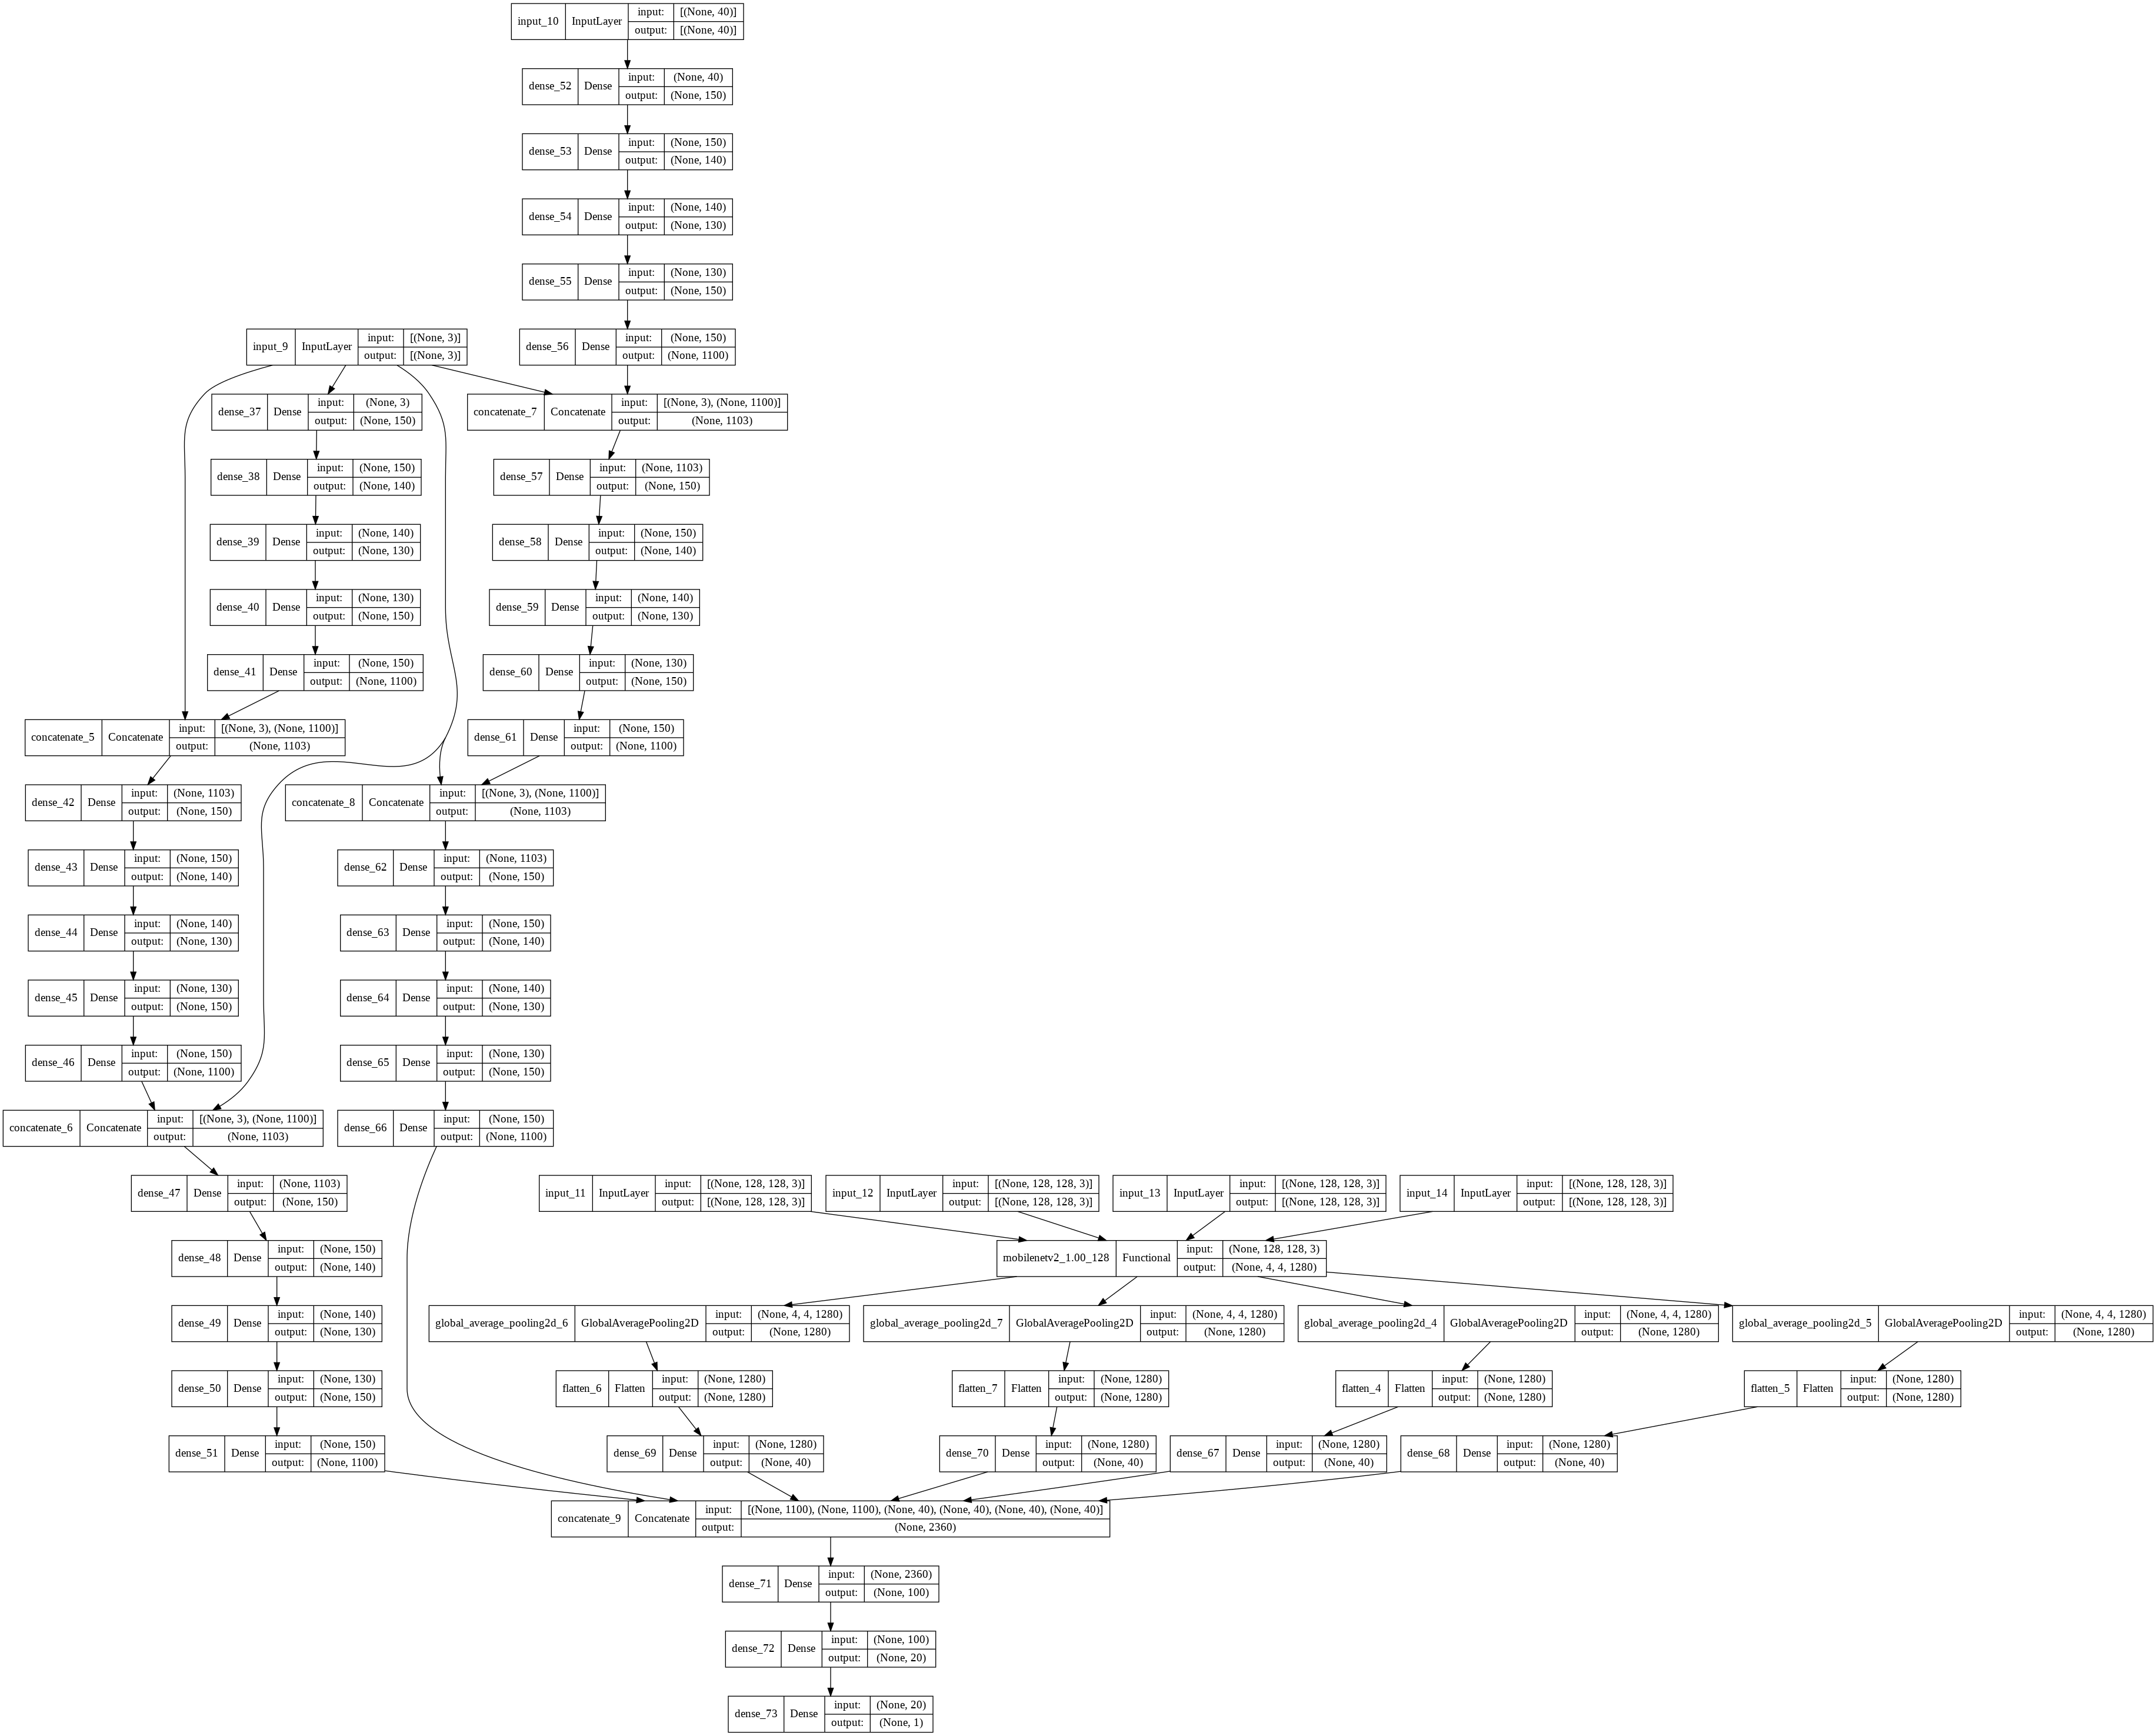

In [22]:


# first input model
def basic_block(visible1):
  dense1 = Dense(150, activation='relu')(visible1)
  dense2 = Dense(140, activation='relu')(dense1)
  dense3 = Dense(130, activation='relu')(dense2)
  dense4 = Dense(150, activation='relu')(dense3)
  output1 = Dense(1100, activation='relu')(dense4)
  return output1


visible1 = Input(shape=3)
output1 = basic_block(visible1)
output2 = basic_block(concatenate([visible1, output1]))
output3 = basic_block(concatenate([visible1, output2]))

zip_code = Input(shape=x_train.shape[1]-3)
output4 = basic_block(zip_code)
output5 = basic_block(concatenate([visible1, output4]))
output6 = basic_block(concatenate([visible1, output5]))

# second input model
image1 = Input(shape=(128,128,3))
image2 = Input(shape=(128,128,3))
image3 = Input(shape=(128,128,3))
image4 = Input(shape=(128,128,3))
	
# add new classifier layers
base_output1 = base_model(image1)
global_average_layer1 = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average1 = global_average_layer1(base_output1)
flat11 = Flatten()(feature_batch_average1)
output71 = Dense(40, activation='relu')(flat11)

base_output2 = base_model(image2)
global_average_layer2 = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average2 = global_average_layer2(base_output2)
flat22 = Flatten()(feature_batch_average2)
output72 = Dense(40, activation='relu')(flat22)

base_output3 = base_model(image3)
global_average_layer3 = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average3 = global_average_layer3(base_output3)
flat33 = Flatten()(feature_batch_average3)
output73 = Dense(40, activation='relu')(flat33)

base_output4 = base_model(image4)
global_average_layer4 = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average4 = global_average_layer4(base_output4)
flat44 = Flatten()(feature_batch_average4)
output74 = Dense(40, activation='relu')(flat44)
# merge input models
merge = concatenate([output3, output6, output71, output72, output73, output74])


# interpretation model
hidden1 = Dense(100, activation='relu')(merge)
hidden3 = Dense(20, activation='relu')(hidden1)
output = Dense(1, activation='linear')(hidden3)


model = Model(inputs=[visible1, zip_code, image1, image2, image3, image4], outputs=output)
# summarize layers
# print(model.summary())
# plot graph
plot_model(model, show_shapes=True)

In [27]:
# from tensorflow.keras.optimizers import Adam
# opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss='mean_absolute_percentage_error', optimizer='adam')



    # ValueError: Input 1 of layer "model_3" is incompatible with the layer: expected shape=(None, 125), found shape=(None, 40

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=69, verbose=2, mode='auto')

model.fit(
	[x_train[:, 0:3], x_train[:, 3:], x_image_train[:,:,:,0:3], x_image_train[:,:,:,3:6], x_image_train[:,:,:,6:9], x_image_train[:,:,:,9:12]], y_train,
	validation_data=([x_val[:, 0:3], x_val[:, 3:], x_image_val[:,:,:,0:3], x_image_val[:,:,:,3:6], x_image_val[:,:,:,6:9], x_image_val[:,:,:,9:12]], y_val),
	epochs=1500, batch_size=32, callbacks = [checkpointer, monitor])


Epoch 1/1500
35/36 [============================>.] - ETA: 0s - loss: 10.1203

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


36/36 [==============================] - 14s 140ms/step - loss: 10.0420 - val_loss: 1.5294
Epoch 2/1500
36/36 [==============================] - 2s 60ms/step - loss: 3.4862 - val_loss: 2.8026
Epoch 3/1500
36/36 [==============================] - 2s 60ms/step - loss: 5.1933 - val_loss: 14.8608
Epoch 4/1500
36/36 [==============================] - 2s 61ms/step - loss: 6.9962 - val_loss: 4.6264
Epoch 5/1500
36/36 [==============================] - 3s 74ms/step - loss: 2.6890 - val_loss: 1.2806
Epoch 6/1500
36/36 [==============================] - 2s 61ms/step - loss: 2.3615 - val_loss: 2.0038
Epoch 7/1500
36/36 [==============================] - 2s 62ms/step - loss: 4.0721 - val_loss: 4.7109
Epoch 8/1500
36/36 [==============================] - 3s 73ms/step - loss: 2.5883 - val_loss: 1.1980
Epoch 9/1500
36/36 [==============================] - 2s 62ms/step - loss: 2.7789 - val_loss: 1.3729
Epoch 10/1500
36/36 [==============================] - 2s 60ms/step - loss: 2.7510 - val_loss: 6.485

In [28]:
from tensorflow.keras.models import load_model
model = load_model("best_weights.hdf5")
ypred = model.predict([x_test[:, 0:3], x_test[:, 3:], x_image_test[:,:,:,0:3], x_image_test[:,:,:,3:6], x_image_test[:,:,:,6:9], x_image_test[:,:,:,9:12]])


In [29]:
score = np.sqrt(metrics.mean_squared_error(ypred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 5583.4580078125


In [30]:
import locale
diff = ypred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $485,935.58, std house price: $216,073.17
[INFO] mean: 1.25%, std: 1.80%


In [31]:
print(ypred[0:5])
print(y_test[0:5])

[[170779.88]
 [885107.4 ]
 [728852.7 ]
 [622756.56]
 [896445.44]]
[175000. 888000. 729000. 625000. 895000.]


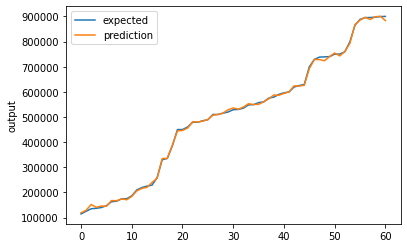

0.9994491462160517


In [32]:
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
ypred = ypred.flatten()
chart_regression(ypred,y_test,sort=True)
print(metrics.r2_score(ypred, y_test))

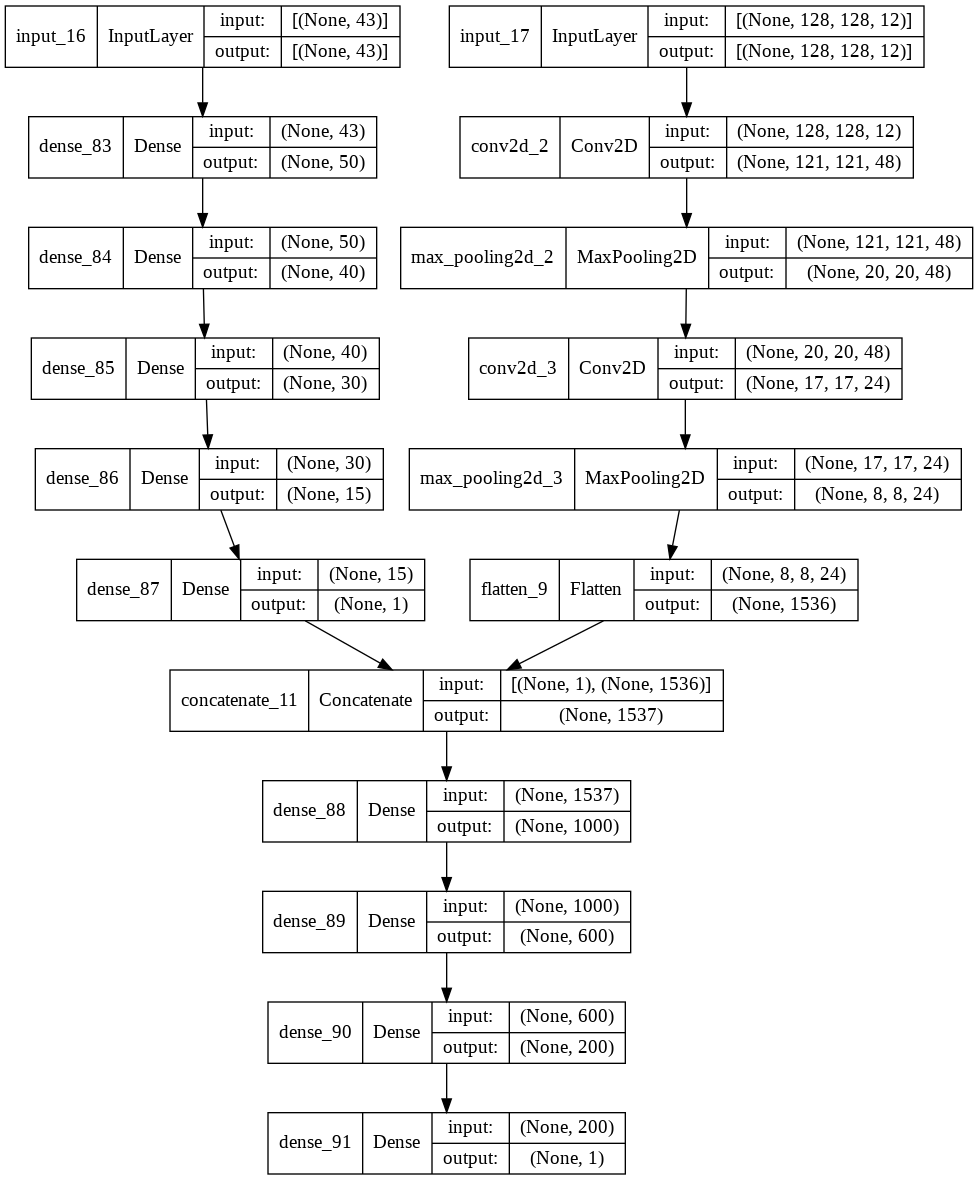

In [32]:
# first input model
visible1 = Input(shape=x_train.shape[1])
dense1 = Dense(50, activation='relu')(visible1)
dense2 = Dense(40, activation='relu')(dense1)
dense3 = Dense(30, activation='relu')(dense2)
dense4 = Dense(15, activation='relu')(dense3)
output1 = Dense(1, activation='relu')(dense4)


# second input model
visible2 = Input(shape=(128,128,12))
conv21 = Conv2D(48, kernel_size=8, activation='relu')(visible2)
pool21 = MaxPooling2D(pool_size=(6, 6))(conv21)
conv22 = Conv2D(24, kernel_size=4, activation='relu')(pool21)
pool22 = MaxPooling2D(pool_size=(2, 2))(conv22)
output2 = Flatten()(pool22)

# merge input models
merge = concatenate([output1, output2])


# interpretation model
hidden1 = Dense(1000, activation='relu')(merge)
hidden2 = Dense(600, activation='relu')(hidden1)
hidden3 = Dense(200, activation='relu')(hidden2)
output = Dense(1, activation='linear')(hidden3)


model = Model(inputs=[visible1, visible2], outputs=output)
# summarize layers
# print(model.summary())
# plot graph
plot_model(model, show_shapes=True)
# print('done')

In [17]:
# from tensorflow.keras.optimizers import Adam
# opt = Adam(lr=1e-3, decay=1e-3 / 200)

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=69, verbose=2, mode='auto')

model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

model.fit(
	[x_train, x_image_train], y_train,
	validation_data=([x_val, x_image_val], y_val),
	epochs=1500, batch_size=4, callbacks = [checkpointer, monitor])


Epoch 1/1500
283/283 [==============================] - 11s 9ms/step - loss: 54.3722 - val_loss: 36.0686
Epoch 2/1500
283/283 [==============================] - 2s 8ms/step - loss: 22.9510 - val_loss: 25.4777
Epoch 3/1500
283/283 [==============================] - 2s 8ms/step - loss: 18.1696 - val_loss: 25.0659
Epoch 4/1500
283/283 [==============================] - 2s 8ms/step - loss: 16.6568 - val_loss: 23.1081
Epoch 5/1500
283/283 [==============================] - 2s 8ms/step - loss: 16.2397 - val_loss: 20.9737
Epoch 6/1500
283/283 [==============================] - 2s 8ms/step - loss: 15.6448 - val_loss: 20.4961
Epoch 7/1500
283/283 [==============================] - 2s 8ms/step - loss: 14.8912 - val_loss: 19.9701
Epoch 8/1500
283/283 [==============================] - 2s 8ms/step - loss: 14.3703 - val_loss: 19.0387
Epoch 9/1500
283/283 [==============================] - 2s 8ms/step - loss: 13.9058 - val_loss: 18.5523
Epoch 10/1500
283/283 [==============================] - 2s 8ms

In [18]:
from tensorflow.keras.models import load_model
model = load_model("best_weights.hdf5")

ypred = model.predict([x_test, x_image_test])


In [19]:
score = np.sqrt(metrics.mean_squared_error(ypred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 43161.3515625


In [20]:
print(x_train[0])

[0.33333334 0.16666667 0.08704592 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.        ]


In [21]:
print(ypred[0:5])
print(y_test[0:5])

[[199632.42]
 [836981.4 ]
 [657809.4 ]
 [615013.75]
 [795415.8 ]]
[175000. 888000. 729000. 625000. 895000.]


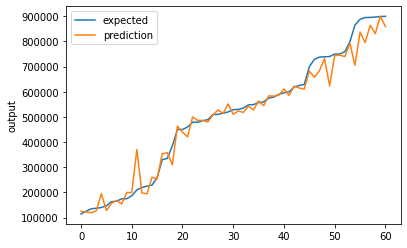

0.962458958531051


In [22]:
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
ypred = ypred.flatten()
chart_regression(ypred,y_test,sort=True)
print(metrics.r2_score(ypred, y_test))

In [42]:

# example of loading the resnet50 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')
# base_model.summary()
base_model.trainable = False


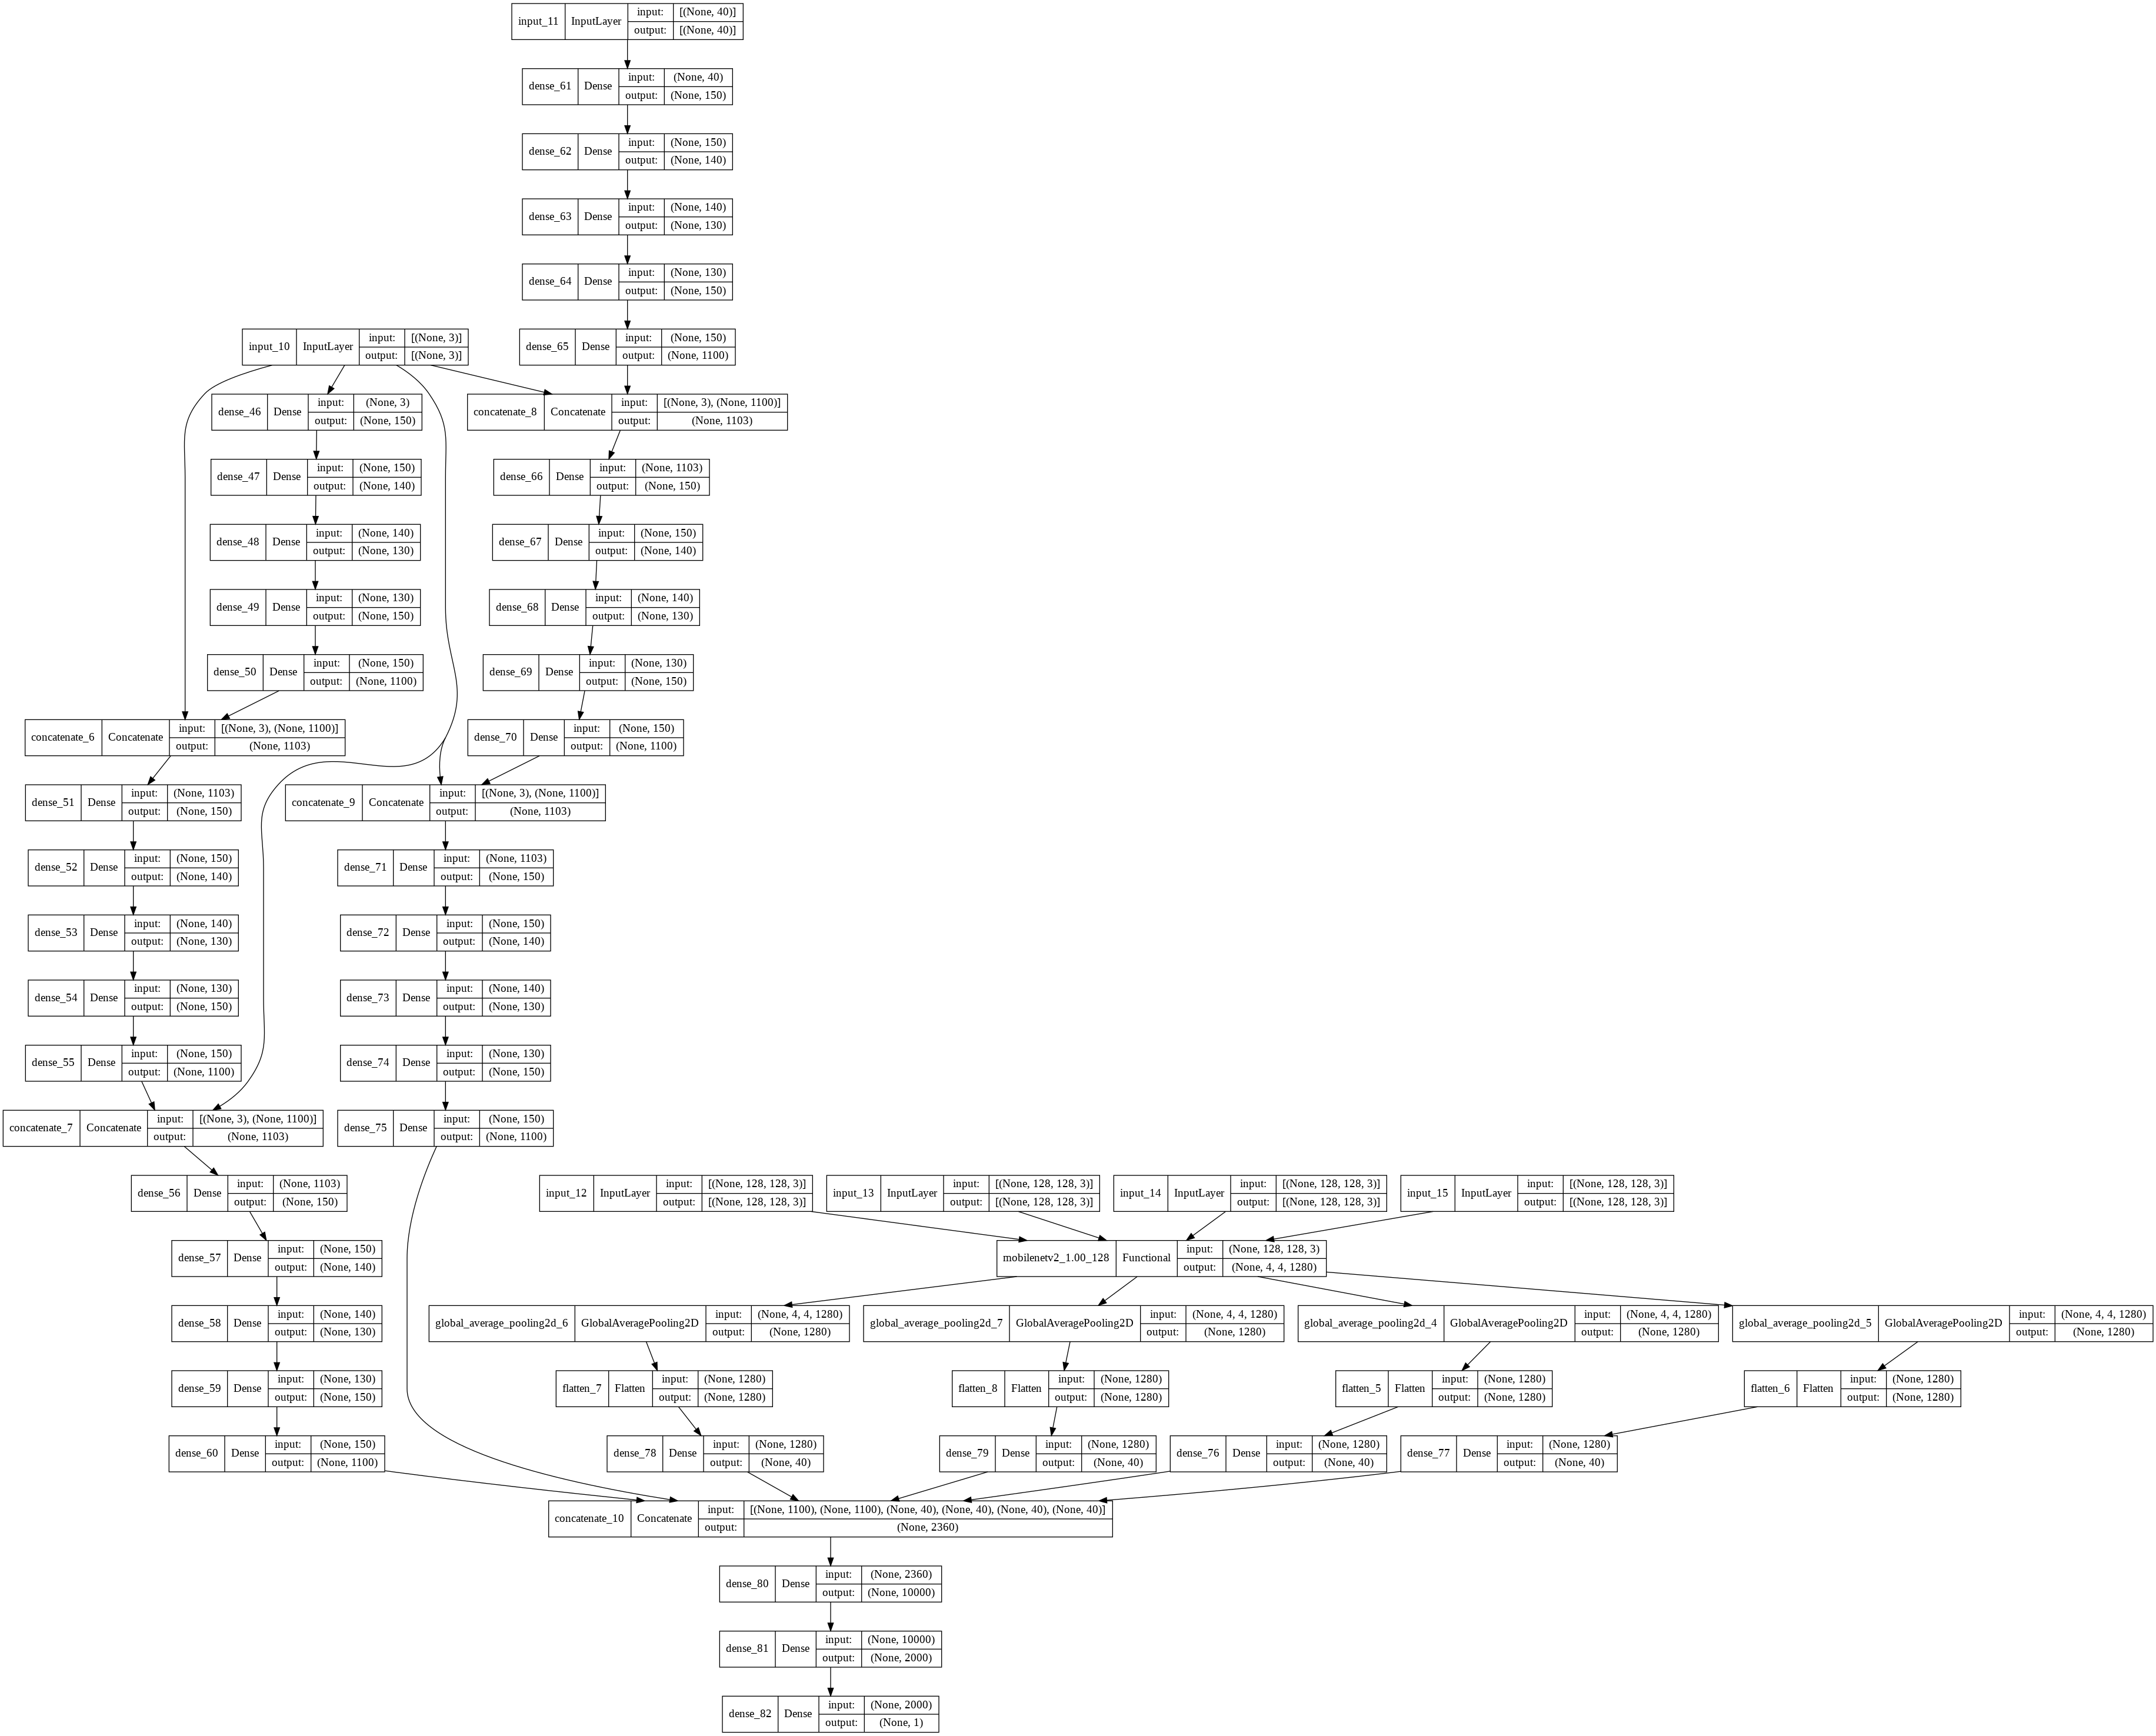

In [31]:


# first input model
def basic_block(visible1):
  dense1 = Dense(150, activation='relu')(visible1)
  dense2 = Dense(140, activation='relu')(dense1)
  dense3 = Dense(130, activation='relu')(dense2)
  dense4 = Dense(150, activation='relu')(dense3)
  output1 = Dense(1100, activation='relu')(dense4)
  return output1


visible1 = Input(shape=3)
output1 = basic_block(visible1)
output2 = basic_block(concatenate([visible1, output1]))
output3 = basic_block(concatenate([visible1, output2]))

zip_code = Input(shape=x_train.shape[1]-3)
output4 = basic_block(zip_code)
output5 = basic_block(concatenate([visible1, output4]))
output6 = basic_block(concatenate([visible1, output5]))

# second input model
image1 = Input(shape=(128,128,3))
image2 = Input(shape=(128,128,3))
image3 = Input(shape=(128,128,3))
image4 = Input(shape=(128,128,3))
	
# add new classifier layers
base_output1 = base_model(image1)
global_average_layer1 = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average1 = global_average_layer1(base_output1)
flat11 = Flatten()(feature_batch_average1)
output71 = Dense(40, activation='relu')(flat11)

base_output2 = base_model(image2)
global_average_layer2 = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average2 = global_average_layer2(base_output2)
flat22 = Flatten()(feature_batch_average2)
output72 = Dense(40, activation='relu')(flat22)

base_output3 = base_model(image3)
global_average_layer3 = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average3 = global_average_layer3(base_output3)
flat33 = Flatten()(feature_batch_average3)
output73 = Dense(40, activation='relu')(flat33)

base_output4 = base_model(image4)
global_average_layer4 = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average4 = global_average_layer4(base_output4)
flat44 = Flatten()(feature_batch_average4)
output74 = Dense(40, activation='relu')(flat44)
# merge input models
merge = concatenate([output3, output6, output71, output72, output73, output74])


# interpretation model
hidden1 = Dense(10000, activation='relu')(merge)
hidden3 = Dense(2000, activation='relu')(hidden1)
output = Dense(1, activation='linear')(hidden3)


model = Model(inputs=[visible1, zip_code, image1, image2, image3, image4], outputs=output)
# summarize layers
# print(model.summary())
# plot graph
plot_model(model, show_shapes=True)

In [25]:
# from tensorflow.keras.optimizers import Adam
# opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss='mean_absolute_percentage_error', optimizer='adam')



    # ValueError: Input 1 of layer "model_3" is incompatible with the layer: expected shape=(None, 125), found shape=(None, 40

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=69, verbose=2, mode='auto')

model.fit(
	[x_train[:, 0:3], x_train[:, 3:], x_image_train[:,:,:,0:3], x_image_train[:,:,:,3:6], x_image_train[:,:,:,6:9], x_image_train[:,:,:,9:12]], y_train,
	validation_data=([x_val[:, 0:3], x_val[:, 3:], x_image_val[:,:,:,0:3], x_image_val[:,:,:,3:6], x_image_val[:,:,:,6:9], x_image_val[:,:,:,9:12]], y_val),
	epochs=1500, batch_size=32, callbacks = [checkpointer, monitor])


Epoch 1/1500
36/36 [==============================] - ETA: 0s - loss: 79.9054

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


36/36 [==============================] - 17s 202ms/step - loss: 79.9054 - val_loss: 42.8269
Epoch 2/1500
36/36 [==============================] - 4s 123ms/step - loss: 33.0859 - val_loss: 26.3352
Epoch 3/1500
36/36 [==============================] - 5s 134ms/step - loss: 19.2621 - val_loss: 22.7369
Epoch 4/1500
36/36 [==============================] - 5s 131ms/step - loss: 13.3611 - val_loss: 10.3828
Epoch 5/1500
36/36 [==============================] - 2s 63ms/step - loss: 11.1406 - val_loss: 11.0169
Epoch 6/1500
36/36 [==============================] - 4s 120ms/step - loss: 5.5055 - val_loss: 9.4264
Epoch 7/1500
36/36 [==============================] - 4s 124ms/step - loss: 6.1592 - val_loss: 8.0151
Epoch 8/1500
36/36 [==============================] - 2s 64ms/step - loss: 6.2655 - val_loss: 10.9217
Epoch 9/1500
36/36 [==============================] - 4s 122ms/step - loss: 3.4945 - val_loss: 7.4838
Epoch 10/1500
36/36 [==============================] - 2s 61ms/step - loss: 4.4932 - 

In [26]:
from tensorflow.keras.models import load_model
model = load_model("best_weights.hdf5")
ypred = model.predict([x_test[:, 0:3], x_test[:, 3:], x_image_test[:,:,:,0:3], x_image_test[:,:,:,3:6], x_image_test[:,:,:,6:9], x_image_test[:,:,:,9:12]])


In [27]:
score = np.sqrt(metrics.mean_squared_error(ypred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 25385.697265625


In [28]:
import locale
diff = ypred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $485,935.58, std house price: $216,073.17
[INFO] mean: 6.39%, std: 9.42%


In [29]:
print(ypred[0:5])
print(y_test[0:5])

[[162809.9 ]
 [877257.9 ]
 [729667.1 ]
 [611295.75]
 [881524.75]]
[175000. 888000. 729000. 625000. 895000.]


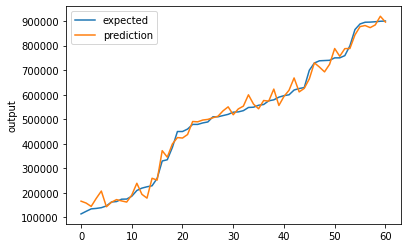

0.9882295528326048


In [30]:
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
ypred = ypred.flatten()
chart_regression(ypred,y_test,sort=True)
print(metrics.r2_score(ypred, y_test))

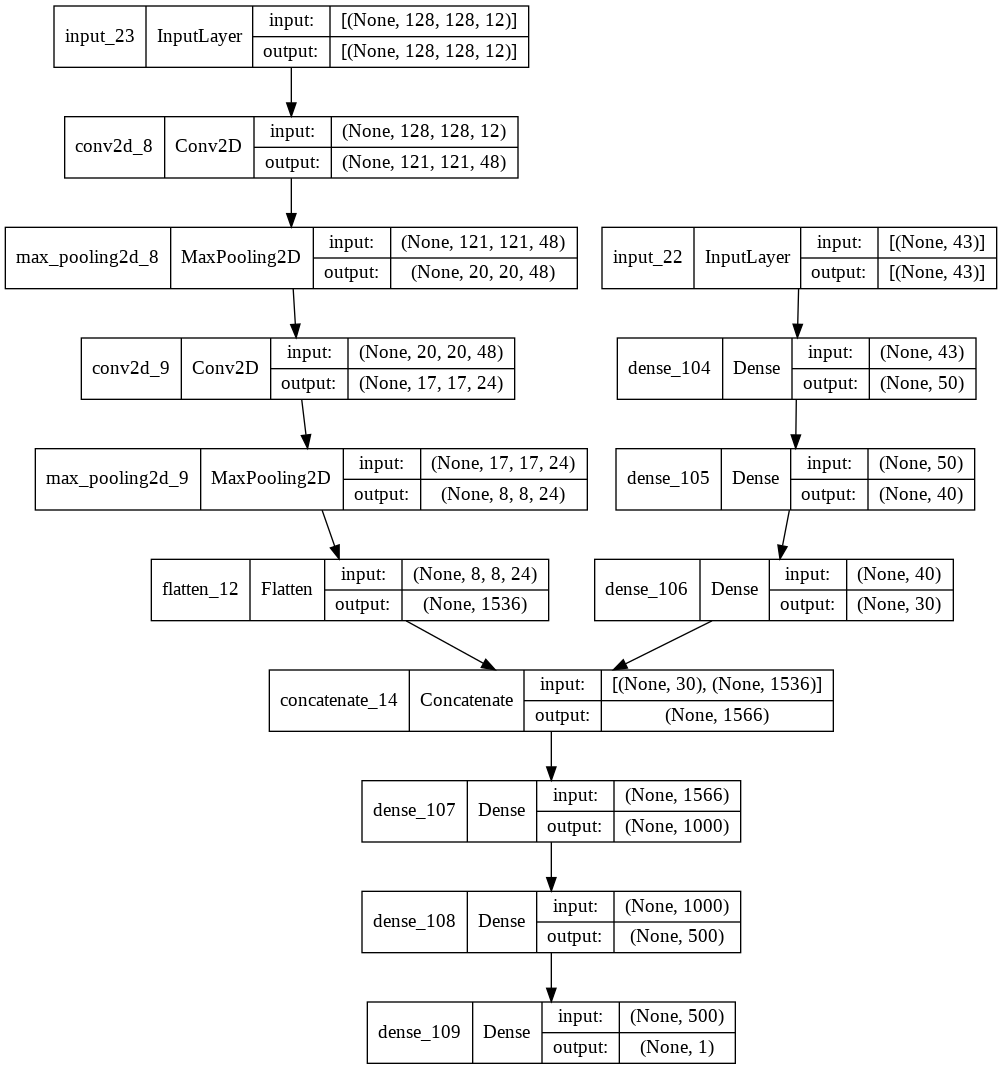

In [35]:
# first input model
visible1 = Input(shape=x_train.shape[1])
dense1 = Dense(50, activation='relu')(visible1)
dense2 = Dense(40, activation='relu')(dense1)
output1 = Dense(30, activation='relu')(dense2)


# second input model
visible2 = Input(shape=(128,128,12))
conv21 = Conv2D(48, kernel_size=8, activation='relu')(visible2)
pool21 = MaxPooling2D(pool_size=(6, 6))(conv21)
conv22 = Conv2D(24, kernel_size=4, activation='relu')(pool21)
pool22 = MaxPooling2D(pool_size=(2, 2))(conv22)
output2 = Flatten()(pool22)

# merge input models
merge = concatenate([output1, output2])


# interpretation model
hidden1 = Dense(1000, activation='relu')(merge)
hidden2 = Dense(500, activation='relu')(hidden1)
output = Dense(1, activation='linear')(hidden2)


model = Model(inputs=[visible1, visible2], outputs=output)
# summarize layers
# print(model.summary())
# plot graph
plot_model(model, show_shapes=True)
# print('done')

In [36]:
# from tensorflow.keras.optimizers import Adam
# opt = Adam(lr=1e-3, decay=1e-3 / 200)

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=69, verbose=2, mode='auto')

model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

model.fit(
	[x_train, x_image_train], y_train,
	validation_data=([x_val, x_image_val], y_val),
	epochs=1500, batch_size=4, callbacks = [checkpointer, monitor])


Epoch 1/1500
283/283 [==============================] - 3s 9ms/step - loss: 55.3382 - val_loss: 39.1161
Epoch 2/1500
283/283 [==============================] - 2s 8ms/step - loss: 26.1590 - val_loss: 26.7361
Epoch 3/1500
283/283 [==============================] - 2s 8ms/step - loss: 18.9348 - val_loss: 24.1841
Epoch 4/1500
283/283 [==============================] - 2s 7ms/step - loss: 17.2235 - val_loss: 24.7838
Epoch 5/1500
283/283 [==============================] - 2s 8ms/step - loss: 15.9157 - val_loss: 21.5361
Epoch 6/1500
283/283 [==============================] - 2s 7ms/step - loss: 15.4772 - val_loss: 21.7815
Epoch 7/1500
283/283 [==============================] - 2s 8ms/step - loss: 14.9341 - val_loss: 20.2751
Epoch 8/1500
283/283 [==============================] - 2s 7ms/step - loss: 14.6559 - val_loss: 20.4966
Epoch 9/1500
283/283 [==============================] - 2s 8ms/step - loss: 14.3218 - val_loss: 19.2725
Epoch 10/1500
283/283 [==============================] - 2s 8ms/

In [37]:
from tensorflow.keras.models import load_model
model = load_model("best_weights.hdf5")

ypred = model.predict([x_test, x_image_test])


In [38]:
score = np.sqrt(metrics.mean_squared_error(ypred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 61230.08984375


In [39]:
print(x_train[0])

[0.33333334 0.16666667 0.08704592 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.        ]


In [40]:
print(ypred[0:5])
print(y_test[0:5])

[[195401.03]
 [869906.25]
 [698143.6 ]
 [628278.8 ]
 [850463.1 ]]
[175000. 888000. 729000. 625000. 895000.]


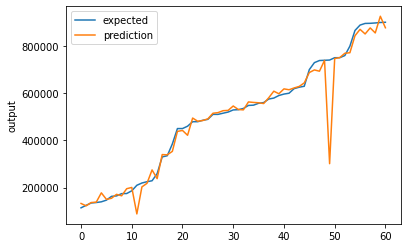

0.9327106984647121


In [41]:
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
ypred = ypred.flatten()
chart_regression(ypred,y_test,sort=True)
print(metrics.r2_score(ypred, y_test))